<a href="https://colab.research.google.com/github/Carol-Kelly/Hamoye_Internship/blob/main/StageE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
uploaded = files.upload()

Saving Time_series_analysis_and_forecast_DATASET.csv to Time_series_analysis_and_forecast_DATASET.csv


In [3]:
df = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
print(f'Dimension of dataset: {df.shape}')

Dimension of dataset: (92016, 5)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [6]:
# check for missing values
df.isna().values.any()

False

In [7]:
# convert timestamp column to datetime
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.set_index('FullDate', inplace = True)

In [8]:
# Downsample to daily data points
df_daily = df.resample('D').sum() 
df_daily

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700
2010-09-02,369.6,38898.99000,88.5600,570.810
2010-09-03,439.2,41665.76000,106.8000,504.975
2010-09-04,328.8,35638.08500,81.3600,502.275
2010-09-05,357.6,35611.41000,106.8000,500.555
...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770
2021-02-25,518.4,4539.07855,130.5048,577.515
2021-02-26,547.2,9517.02430,130.1808,1445.495


**Visualization of Resampled data from an hour sampling rate to a daily sampling rate**

Text(0, 0.5, 'ElecPrice_Sampled')

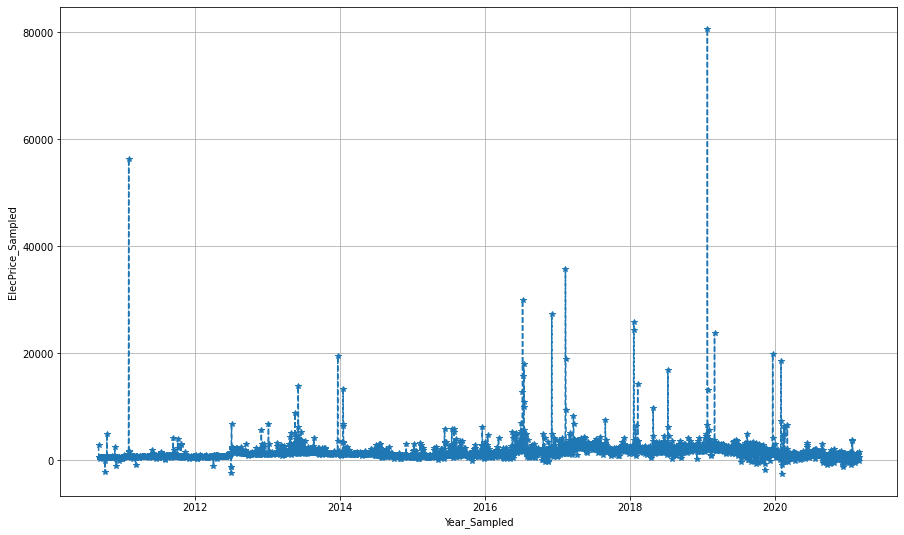

In [9]:
plt.figure(figsize=(15,9))
plt.plot(df_daily.index, df_daily.ElecPrice, '--', marker='*')
plt.grid()
plt.xlabel('Year_Sampled')
plt.ylabel('ElecPrice_Sampled')

**P-value of the SysLoad and GasPrice of the resampled Data set using the Augmented Dicky Fuller test (ADF) to 6 decimal places.**

In [10]:
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df_daily['SysLoad'])
print(f'P-value of SysLoad: {round(adf1[1], 6)}')

P-value of SysLoad: 0.004254


In [11]:
adf2 = adfuller(df_daily['GasPrice'])
print(f'P-value of GasPrice: {round(adf2[1], 6)}')

P-value of GasPrice: 0.045027


**The 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set to 4 decimal places, using the Augmented Dicky Fuller test (ADF)**

In [12]:
print('Critical values of GasPrice:')
for k, v in adf2[4].items():
  print(f' {k} : {round(v, 4)}')

Critical values of GasPrice:
 1% : -3.4321
 5% : -2.8623
 10% : -2.5672


In [13]:
adf3 = adfuller(df_daily['ElecPrice'])
print('Critical values of ElecPrice:')
for k, v in adf3[4].items():
  print(f' {k} : {round(v, 4)}')

Critical values of ElecPrice:
 1% : -3.4321
 5% : -2.8623
 10% : -2.5672


### **Univariate model with Facebook Prophet**

In [14]:
# remame the df in an acceptable format
data = df_daily.reset_index().rename({'FullDate':'ds', 'ElecPrice':'y'}, axis=1)  
data.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [15]:
# divide the data into train and test sets
test_size = (len(df_daily) - 2757)

train_data = data[:-test_size]
test_data = data[-test_size:]

In [16]:
test_data.head()

,ds,Tmax,SysLoad,GasPrice,y
2757,2018-03-20,540.0,7696.91130,201.5880,1833.00
2758,2018-03-21,571.2,4658.05865,203.2560,1730.49
2759,2018-03-22,722.4,19161.78525,203.2560,2260.55
2760,2018-03-23,811.2,18090.43435,198.6456,2138.76
2761,2018-03-24,832.8,3763.53865,180.2160,1721.70


In [17]:
train_data.tail() 

,ds,Tmax,SysLoad,GasPrice,y
2752,2018-03-15,609.6,27139.02585,220.6272,2717.340
2753,2018-03-16,648.0,19710.46400,216.9600,2277.335
2754,2018-03-17,724.8,1079.34705,209.0400,1718.385
2755,2018-03-18,508.8,-4102.43795,203.9880,1088.015
2756,2018-03-19,561.6,8731.39945,199.2720,1998.305


In [18]:
model = Prophet()
model.fit(train_data) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future = model.make_future_dataframe(periods=len(test_data), freq='D')

In [20]:
future.head()

,ds
0,2010-09-01
1,2010-09-02
2,2010-09-03
3,2010-09-04
4,2010-09-05


In [21]:
forecast = model.predict(future)

In [22]:
# summarize the forecast
print(len(forecast))
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

3834
          ds         yhat   yhat_lower   yhat_upper
0 2010-09-01   996.028134 -1402.139652  3480.763539
1 2010-09-02  1076.181083 -1245.775924  3488.920942
2 2010-09-03   851.092206 -1670.792222  3258.111328
3 2010-09-04   510.753732 -1736.791635  2849.003655
4 2010-09-05   420.690845 -2055.324082  2914.788807


**Mean absolute percentage error of univariate time series model on the test set in 2 decimal places**

In [23]:
def mean_absolute_percentage_error(y_true, y_pred):
  return (np.mean(np.abs((y_true - y_pred) / y_true))) * 100
    
y_true = test_data['y'].values
y_pred = forecast['yhat'][-test_size:].values

mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print(f'MAPE of Univariate model: {mape}')  

MAPE of Univariate model: 549.48


In [24]:
# RMSE of univariate model in 2 decimal places
rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
print(f'RMSE of univariate model: {rmse}')

RMSE of univariate model: 3218.16


**Plot the components from the forecasted model, the month of the yearly seasonality with the highest value**

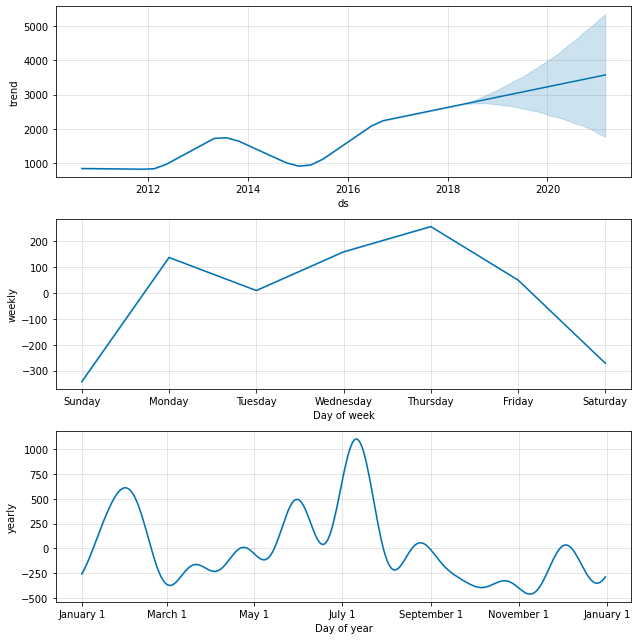

In [25]:
# plots component of the forecast
f = model.plot_components(forecast)

### **Multivariate Analysis using Facebook Prophet**

In [26]:
multivariate_analysis = df_daily.reset_index()[['FullDate','SysLoad','Tmax','GasPrice','ElecPrice']].rename(
    {'FullDate':'ds', 'SysLoad':'add1', 'Tmax':'add2', 'GasPrice':'add3', 'ElecPrice':'y'}, axis=1
)
multivariate_analysis.head()

,ds,add1,add2,add3,y
0,2010-09-01,41565.380,379.2,88.56,2751.700
1,2010-09-02,38898.990,369.6,88.56,570.810
2,2010-09-03,41665.760,439.2,106.80,504.975
3,2010-09-04,35638.085,328.8,81.36,502.275
4,2010-09-05,35611.410,357.6,106.80,500.555


In [27]:
# split the data_with_regressors dataset
data_train = multivariate_analysis[0:2757]
data_test = multivariate_analysis[2757:]

In [28]:
# we first instantiates a new fbprophet model
model2 = Prophet()

Add regressors to the model using the add_regressor method

In [29]:
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')

In [30]:
# fit the new model
model2.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# make the future DataFrame
future2 = model2.make_future_dataframe(periods=len(data_test), freq='D')
future2.tail()

,ds
3829,2021-02-24
3830,2021-02-25
3831,2021-02-26
3832,2021-02-27
3833,2021-02-28


In [32]:
future2['add1'] = multivariate_analysis['add1']
future2['add2'] = multivariate_analysis['add2']
future2['add3'] = multivariate_analysis['add3']
future2

,ds,add1,add2,add3
0,2010-09-01,41565.38000,379.2,88.5600
1,2010-09-02,38898.99000,369.6,88.5600
2,2010-09-03,41665.76000,439.2,106.8000
3,2010-09-04,35638.08500,328.8,81.3600
4,2010-09-05,35611.41000,357.6,106.8000
...,...,...,...,...
3829,2021-02-24,-1525.49745,537.6,134.4000
3830,2021-02-25,4539.07855,518.4,130.5048
3831,2021-02-26,9517.02430,547.2,130.1808
3832,2021-02-27,4932.88015,564.0,130.0800


In [33]:
# forecast using the extra-regressors as predictors
forecast2 = model2.predict(future2)
print(forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2010-09-01  1517.026982  -764.711944  3769.679388
1 2010-09-02  1469.066011  -767.608349  3744.374020
2 2010-09-03  1699.128738  -430.082440  4021.643776
3 2010-09-04   912.988678 -1302.730511  3128.853740
4 2010-09-05  1331.257873  -904.503305  3602.197928


In [34]:
y_true = data_test['y'].values
y_pred = forecast2['yhat'][2757:].values

mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print(f'MAPE of Multivariate model: {mape}')

MAPE of Multivariate model: 233.74


In [35]:
# RMSE of multivariate model in 2 decimal places
rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
print(f'RMSE of Multivariate model: {rmse}')

RMSE of Multivariate model: 2709.65


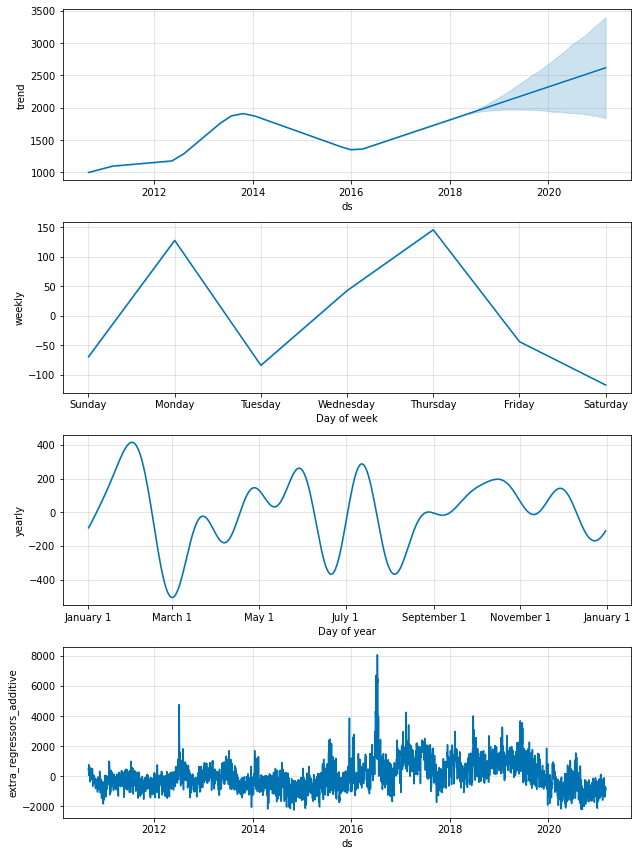

In [36]:
f = model2.plot_components(forecast2)

**Multivariate analysis without 'Tmax'**

In [37]:
data_train1 = data_train.drop(['add2'], axis=1)
data_train1.head()

,ds,add1,add3,y
0,2010-09-01,41565.380,88.56,2751.700
1,2010-09-02,38898.990,88.56,570.810
2,2010-09-03,41665.760,106.80,504.975
3,2010-09-04,35638.085,81.36,502.275
4,2010-09-05,35611.410,106.80,500.555


In [38]:
model3 = Prophet()

In [39]:
model3.add_regressor('add1')
model3.add_regressor('add3')

In [40]:
model3.fit(data_train1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future3 = model3.make_future_dataframe(periods=len(data_test), freq='D')

In [42]:
multivar = df_daily.reset_index()[['FullDate','SysLoad','GasPrice','ElecPrice']].rename(
    {'FullDate':'ds', 'SysLoad':'add1', 'GasPrice':'add3', 'ElecPrice':'y'}, axis=1
)
multivar.head()

,ds,add1,add3,y
0,2010-09-01,41565.380,88.56,2751.700
1,2010-09-02,38898.990,88.56,570.810
2,2010-09-03,41665.760,106.80,504.975
3,2010-09-04,35638.085,81.36,502.275
4,2010-09-05,35611.410,106.80,500.555


In [43]:
future3['add1'] = multivar['add1']
future3['add3'] = multivar['add3']
future3

,ds,add1,add3
0,2010-09-01,41565.38000,88.5600
1,2010-09-02,38898.99000,88.5600
2,2010-09-03,41665.76000,106.8000
3,2010-09-04,35638.08500,81.3600
4,2010-09-05,35611.41000,106.8000
...,...,...,...
3829,2021-02-24,-1525.49745,134.4000
3830,2021-02-25,4539.07855,130.5048
3831,2021-02-26,9517.02430,130.1808
3832,2021-02-27,4932.88015,130.0800


In [44]:
forecast3 = model3.predict(future3)

In [45]:
y_true = data_test['y'].values
y_pred = forecast3['yhat'][2757:].values

mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print(f'MAPE of Multivariate model  without Tmax: {mape}')

MAPE of Multivariate model  without Tmax: 236.66
